### 1. Imports + path setup

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parents[0]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print("Project root:", ROOT)


Project root: C:\Users\hyeon\Documents\miniconda_medimg_env\medimg_baseline_cls


### 2. Load config and rebuild data/loaders

In [2]:
from pathlib import Path
from src.utils import load_json
from src.config import Config, seed_everything

RUNS_ROOT = Path("outputs") / "runs"

# 1) Read latest pointer (created by 01_train)
latest_meta = load_json(str(RUNS_ROOT / "_latest_run.json"))

# Common patterns: latest_meta["run_dir"] might be absolute or relative.
run_dir = Path(latest_meta["run_dir"])
if not run_dir.is_absolute():
    run_dir = (Path.cwd() / run_dir).resolve()

# 2) Load the pure config from that run folder
cfg_dict = load_json(str(run_dir / "config.json"))
cfg = Config(**cfg_dict)

# 3) Optionally attach run_dir for convenience
cfg.run_dir = str(run_dir)

seed_everything(cfg.seed, cfg.deterministic)
print("Using run_dir:", run_dir)
print(cfg)


Using run_dir: C:\Users\hyeon\Documents\miniconda_medimg_env\medimg_baseline_cls\notebooks\outputs\runs\medimg_baseline_cls_20260110_182220
Config(project_name='medimg_baseline_cls', data_root='C:\\Users\\hyeon\\Documents\\miniconda_medimg_env\\data\\chest_xray', output_root='outputs', class_names=['NORMAL', 'PNEUMONIA'], pos_class_name='PNEUMONIA', image_size=[224, 224], rebuild_balanced_val=True, val_n_per_class=200, batch_size=32, num_workers=0, pin_memory=True, max_epochs=10, head_epochs=2, lr_head=0.003, lr_finetune=0.001, weight_decay=0.0001, use_weighted_sampler=True, seed=42, deterministic=False, device='cuda', save_best_by='val_ap', save_history=True, gradcam_alpha=0.35)


In [3]:
from src.data import build_datasets, build_loaders

ds = build_datasets(
    root_dir=cfg.data_root,
    class_names=cfg.class_names,
    image_size=cfg.image_size,
    rebuild_balanced_val=cfg.rebuild_balanced_val,
    val_n_per_class=cfg.val_n_per_class,
    seed=cfg.seed,
)

loaders = build_loaders(
    train_ds=ds["train_ds"],
    val_ds=ds["val_ds"],
    test_ds=ds["test_ds"],
    train_items=ds["train_items"],
    class_names=cfg.class_names,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
    use_weighted_sampler=cfg.use_weighted_sampler,
)

train_loader = loaders["train_loader"]
val_loader   = loaders["val_loader"]
test_loader  = loaders["test_loader"]

train_items = ds["train_items"]
val_items   = ds["val_items"]
test_items  = ds["test_items"]


C:\Users\hyeon\miniconda3\envs\medimg\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
C:\Users\hyeon\miniconda3\envs\medimg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3. Load model + best checkpoint

In [5]:
import torch
import torch.nn as nn

from src.models import build_model, get_gradcam_target_layer

arch = "resnet18"  # must match what you trained with; later you can store in config if desired
model = build_model(arch=arch, num_classes=len(cfg.class_names), pretrained=False, device=cfg.device)

best_ckpt_path = str(Path(run_dir) / "best.pt")
state = torch.load(best_ckpt_path, map_location="cpu")
model.load_state_dict(state)
model.to(cfg.device)
model.eval()

criterion = nn.CrossEntropyLoss()
target_layer = get_gradcam_target_layer(model, arch)

print("Loaded checkpoint:", best_ckpt_path)
print("Grad-CAM target layer:", target_layer)


Loaded checkpoint: C:\Users\hyeon\Documents\miniconda_medimg_env\medimg_baseline_cls\notebooks\outputs\runs\medimg_baseline_cls_20260110_182220\best.pt
Grad-CAM target layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


C:\Users\hyeon\AppData\Local\Temp\ipykernel_39256\759570070.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(best_ckpt_path, map_location="cpu")


### 4. Evaluate VAL/TEST + thresholding + hard errors

In [6]:
import numpy as np
import sklearn.metrics as skm

from src.eval import (
    eval_split,
    metrics_at_threshold,
    pick_threshold_max_f1,
    pick_threshold_target_sens,
    find_errors_binary,
)

val_out = eval_split(
    model=model, loader=val_loader, device=cfg.device, criterion=criterion,
    class_names=cfg.class_names, pos_class_name=cfg.pos_class_name
)
test_out = eval_split(
    model=model, loader=test_loader, device=cfg.device, criterion=criterion,
    class_names=cfg.class_names, pos_class_name=cfg.pos_class_name
)

print("=== Checkpoint performance ===")
print(f"VAL  | loss={val_out['loss']:.4f} acc={val_out['acc']:.4f} AP={val_out.get('ap', float('nan')):.4f}")
print(f"TEST | loss={test_out['loss']:.4f} acc={test_out['acc']:.4f} AP={test_out.get('ap', float('nan')):.4f}")

# Thresholds from VAL
thr_f1, best_f1 = pick_threshold_max_f1(val_out["y_true"], val_out["y_score"])
m_val_f1 = metrics_at_threshold(val_out["y_true"], val_out["y_score"], thr_f1)

TARGET_SENS = 0.95
thr_sens, m_val_sens = pick_threshold_target_sens(val_out["y_true"], val_out["y_score"], target_sens=TARGET_SENS)

print("\n=== Thresholds selected on VAL ===")
print(f"Max-F1 threshold: {thr_f1:.4f} (F1={best_f1:.3f})")
print("VAL metrics @ thr_f1:", {k: v for k, v in m_val_f1.items() if k != "confusion_matrix"})

print(f"\nTarget-sensitivity threshold: {thr_sens:.4f} (target sens >= {TARGET_SENS})")
print("VAL metrics @ thr_sens:", {k: v for k, v in m_val_sens.items() if k != "confusion_matrix"})

# Apply thresholds to TEST
m_test_f1 = metrics_at_threshold(test_out["y_true"], test_out["y_score"], thr_f1)
m_test_sens = metrics_at_threshold(test_out["y_true"], test_out["y_score"], thr_sens)

print("\n=== TEST metrics using thresholds chosen on VAL ===")
print(f"\n[TEST @ Max-F1 thr={thr_f1:.4f}]")
print({k: v for k, v in m_test_f1.items() if k != "confusion_matrix"})

print(f"\n[TEST @ TargetSens thr={thr_sens:.4f} (target sens {TARGET_SENS})]")
print({k: v for k, v in m_test_sens.items() if k != "confusion_matrix"})

print("\nConfusion matrix format: [[TN, FP],[FN, TP]]")
print("\nTEST confusion @ thr_f1:\n", m_test_f1["confusion_matrix"])
print("\nTEST confusion @ thr_sens:\n", m_test_sens["confusion_matrix"])

# Hard errors (use Max-F1 threshold by default)
errs = find_errors_binary(
    items=test_items,
    y_score=test_out["y_score"],
    pos_idx=test_out["pos_idx"],
    thr=thr_f1,
    topk=10,
)
fp_idx = errs["fp_idx"]
fn_idx = errs["fn_idx"]

print("\n=== Hard errors on TEST (Max-F1 threshold) ===")
print("Top false positives:")
for i in fp_idx:
    print(f"  score={test_out['y_score'][i]:.3f} | path={test_items[i]['image']}")
print("\nTop false negatives:")
for i in fn_idx:
    print(f"  score={test_out['y_score'][i]:.3f} | path={test_items[i]['image']}")


=== Checkpoint performance ===
VAL  | loss=0.0409 acc=0.9925 AP=0.9997
TEST | loss=0.8746 acc=0.8590 AP=0.9497

=== Thresholds selected on VAL ===
Max-F1 threshold: 0.4798 (F1=0.995)
VAL metrics @ thr_f1: {'tn': 200, 'fp': 0, 'fn': 2, 'tp': 198, 'sensitivity': 0.99, 'specificity': 1.0, 'ppv': 1.0, 'npv': 0.9900990099009901, 'accuracy': 0.995}

Target-sensitivity threshold: 0.9165 (target sens >= 0.95)
VAL metrics @ thr_sens: {'tn': 200, 'fp': 0, 'fn': 10, 'tp': 190, 'sensitivity': 0.95, 'specificity': 1.0, 'ppv': 1.0, 'npv': 0.9523809523809523, 'accuracy': 0.975}

=== TEST metrics using thresholds chosen on VAL ===

[TEST @ Max-F1 thr=0.4798]
{'tn': 147, 'fp': 87, 'fn': 2, 'tp': 388, 'sensitivity': 0.9948717948717949, 'specificity': 0.6282051282051282, 'ppv': 0.8168421052631579, 'npv': 0.9865771812080537, 'accuracy': 0.8573717948717948}

[TEST @ TargetSens thr=0.9165 (target sens 0.95)]
{'tn': 175, 'fp': 59, 'fn': 10, 'tp': 380, 'sensitivity': 0.9743589743589743, 'specificity': 0.74786

### 5. Grad-CAM: display a few and save batches to disk

=== Show Grad-CAM: first 2 FPs ===


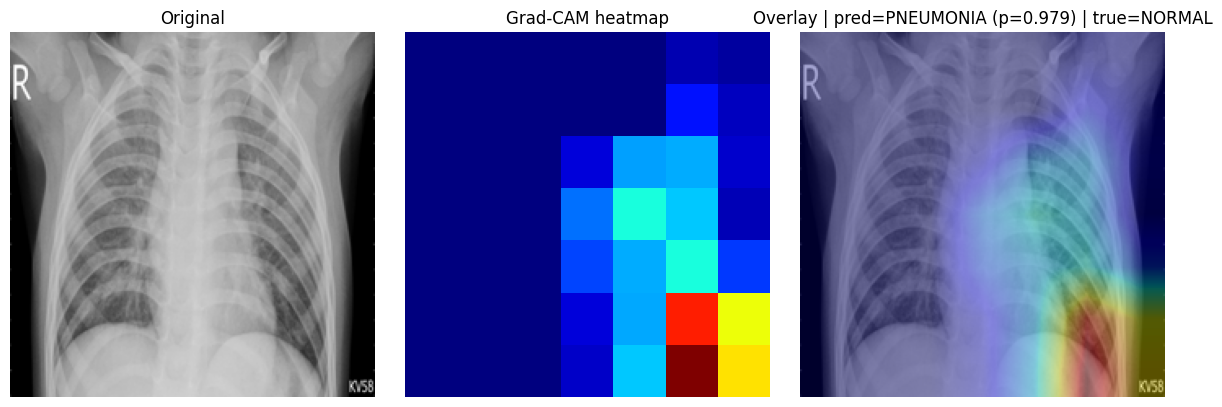

Path: C:\Users\hyeon\Documents\miniconda_medimg_env\data\chest_xray\test\NORMAL\NORMAL2-IM-0246-0001.jpeg
Probabilities: {'NORMAL': 0.021387986838817596, 'PNEUMONIA': 0.978611946105957}


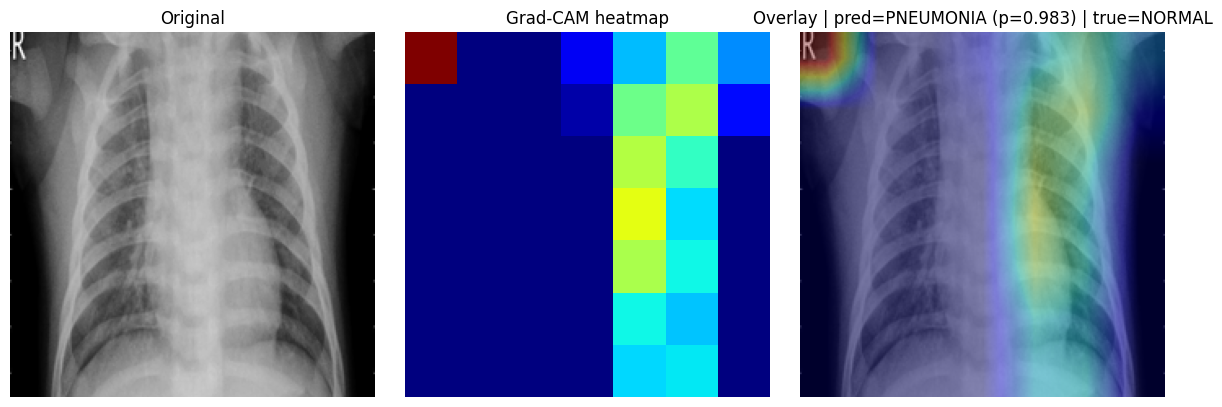

Path: C:\Users\hyeon\Documents\miniconda_medimg_env\data\chest_xray\test\NORMAL\NORMAL2-IM-0256-0001.jpeg
Probabilities: {'NORMAL': 0.016972998157143593, 'PNEUMONIA': 0.9830270409584045}

=== Show Grad-CAM: first 1 FN ===


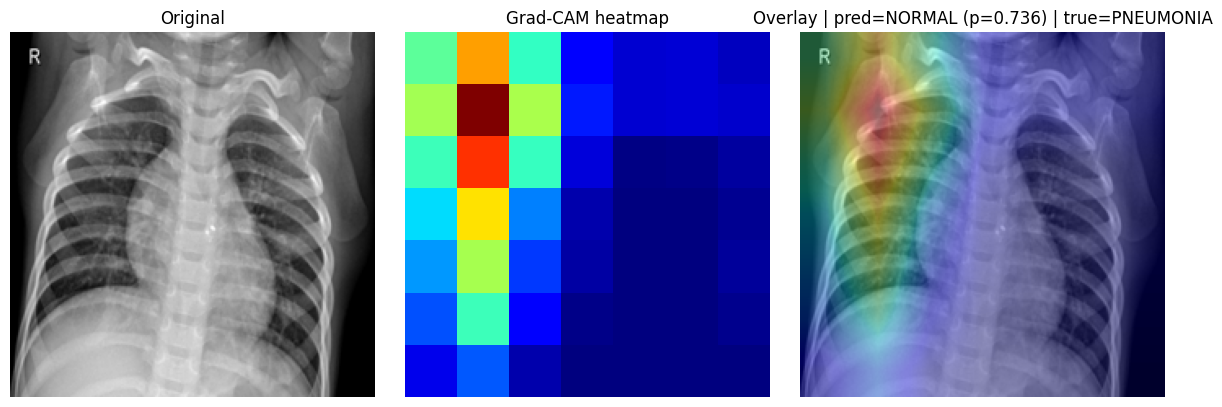

Path: C:\Users\hyeon\Documents\miniconda_medimg_env\data\chest_xray\test\PNEUMONIA\person154_bacteria_728.jpeg
Probabilities: {'NORMAL': 0.7363962531089783, 'PNEUMONIA': 0.26360374689102173}
Saved FP panels: 10 to C:\Users\hyeon\Documents\miniconda_medimg_env\medimg_baseline_cls\notebooks\outputs\runs\medimg_baseline_cls_20260110_182220\gradcam\FP
Saved FN panels: 2 to C:\Users\hyeon\Documents\miniconda_medimg_env\medimg_baseline_cls\notebooks\outputs\runs\medimg_baseline_cls_20260110_182220\gradcam\FN


In [9]:
from src.interpret import GradCAM, show_gradcam, save_gradcam_batch, infer_true_label_from_path

gradcam = GradCAM(model, target_layer)

# Show a couple interactively
print("=== Show Grad-CAM: first 2 FPs ===")
for i in fp_idx[:2]:
    p = test_items[i]["image"]
    show_gradcam(
        model=model,
        gradcam=gradcam,
        path=p,
        class_names=cfg.class_names,
        pos_class_name=cfg.pos_class_name,
        device=cfg.device,
        image_size=cfg.image_size,
        true_label_name=infer_true_label_from_path(p),
    )

print("\n=== Show Grad-CAM: first 1 FN ===")
for i in fn_idx[:1]:
    p = test_items[i]["image"]
    show_gradcam(
        model=model,
        gradcam=gradcam,
        path=p,
        class_names=cfg.class_names,
        pos_class_name=cfg.pos_class_name,
        device=cfg.device,
        image_size=cfg.image_size,
        true_label_name=infer_true_label_from_path(p),
    )

# Save panels to disk under the run directory
out_dir = Path(run_dir) / "gradcam"
fp_paths = [test_items[i]["image"] for i in fp_idx]
fn_paths = [test_items[i]["image"] for i in fn_idx]

records_fp = save_gradcam_batch(
    model=model,
    gradcam=gradcam,
    paths=fp_paths,
    out_dir=str(out_dir / "FP"),
    class_names=cfg.class_names,
    device=cfg.device,
    image_size=cfg.image_size,
    alpha=cfg.gradcam_alpha,
)

records_fn = save_gradcam_batch(
    model=model,
    gradcam=gradcam,
    paths=fn_paths,
    out_dir=str(out_dir / "FN"),
    class_names=cfg.class_names,
    device=cfg.device,
    image_size=cfg.image_size,
    alpha=cfg.gradcam_alpha,
)

print("Saved FP panels:", len(records_fp), "to", out_dir / "FP")
print("Saved FN panels:", len(records_fn), "to", out_dir / "FN")


### 6. (Optional) Save evaluation summary JSON

In [11]:
from src.utils import save_json

summary = {
    "val": {
        "loss": float(val_out["loss"]),
        "acc": float(val_out["acc"]),
        "ap": float(val_out.get("ap", float("nan"))),
        "thr_f1": float(thr_f1),
        "thr_sens": float(thr_sens),
    },
    "test": {
        "loss": float(test_out["loss"]),
        "acc": float(test_out["acc"]),
        "ap": float(test_out.get("ap", float("nan"))),
        "metrics_at_thr_f1": {k: v for k, v in m_test_f1.items() if k != "confusion_matrix"},
        "metrics_at_thr_sens": {k: v for k, v in m_test_sens.items() if k != "confusion_matrix"},
        "cm_thr_f1": m_test_f1["confusion_matrix"].tolist(),
        "cm_thr_sens": m_test_sens["confusion_matrix"].tolist(),
    },
}

save_json(summary, str(Path(run_dir) / "eval_summary.json"))
print("Saved:", Path(run_dir) / "eval_summary.json")


Saved: C:\Users\hyeon\Documents\miniconda_medimg_env\medimg_baseline_cls\notebooks\outputs\runs\medimg_baseline_cls_20260110_182220\eval_summary.json


In [12]:
fp_paths = [test_items[i]["image"] for i in fp_idx[:10]]
fn_paths = [test_items[i]["image"] for i in fn_idx[:10]]

out_dir = r"medimg_baseline_cls\outputs\gradcam_test_errors"
records_fp = save_gradcam_batch(model, gradcam, fp_paths, out_dir + r"\FP", cfg.class_names, cfg.device, cfg.image_size)
records_fn = save_gradcam_batch(model, gradcam, fn_paths, out_dir + r"\FN", cfg.class_names, cfg.device, cfg.image_size)

print("Saved FP Grad-CAM panels:", len(records_fp))
print("Saved FN Grad-CAM panels:", len(records_fn))


Saved FP Grad-CAM panels: 10
Saved FN Grad-CAM panels: 2
